✅ Datos cargados correctamente.


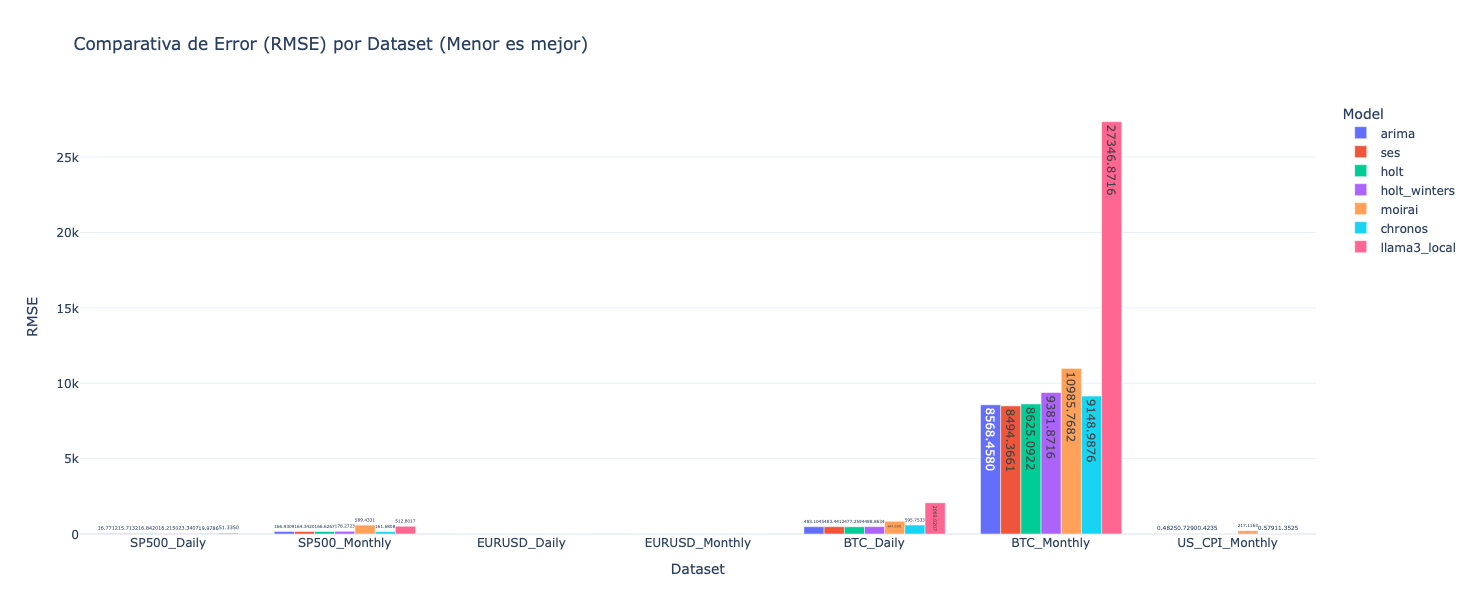

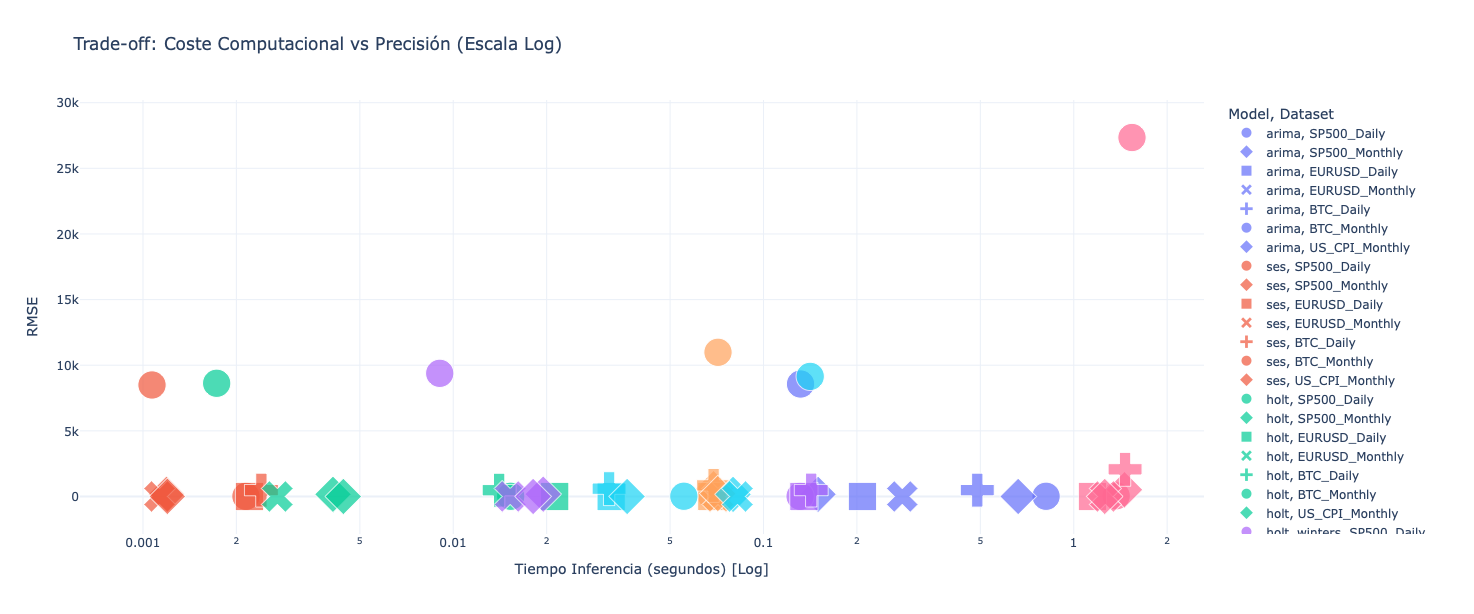

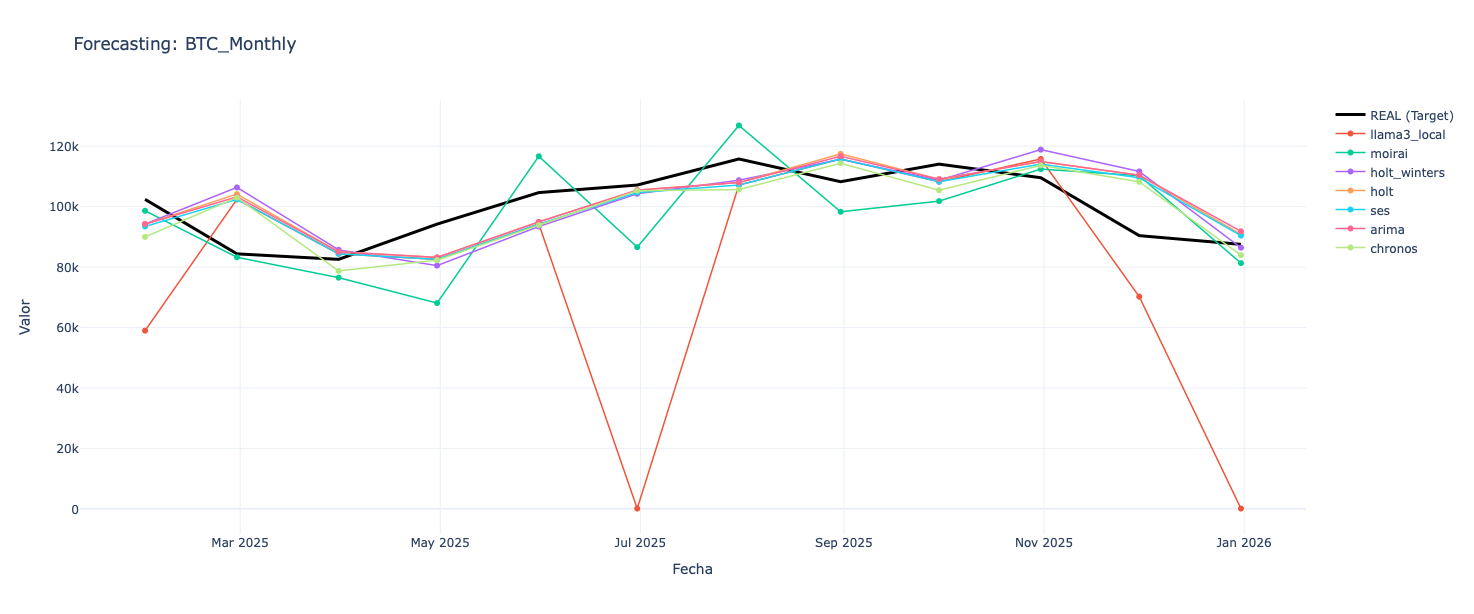

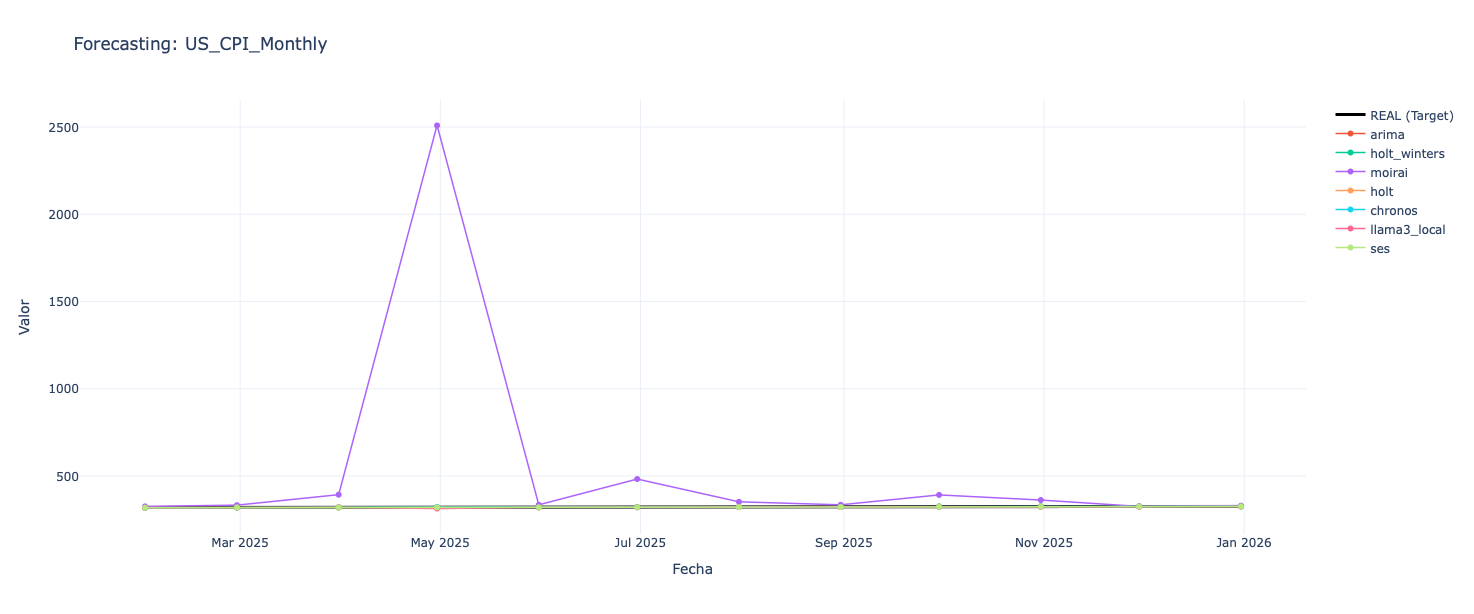

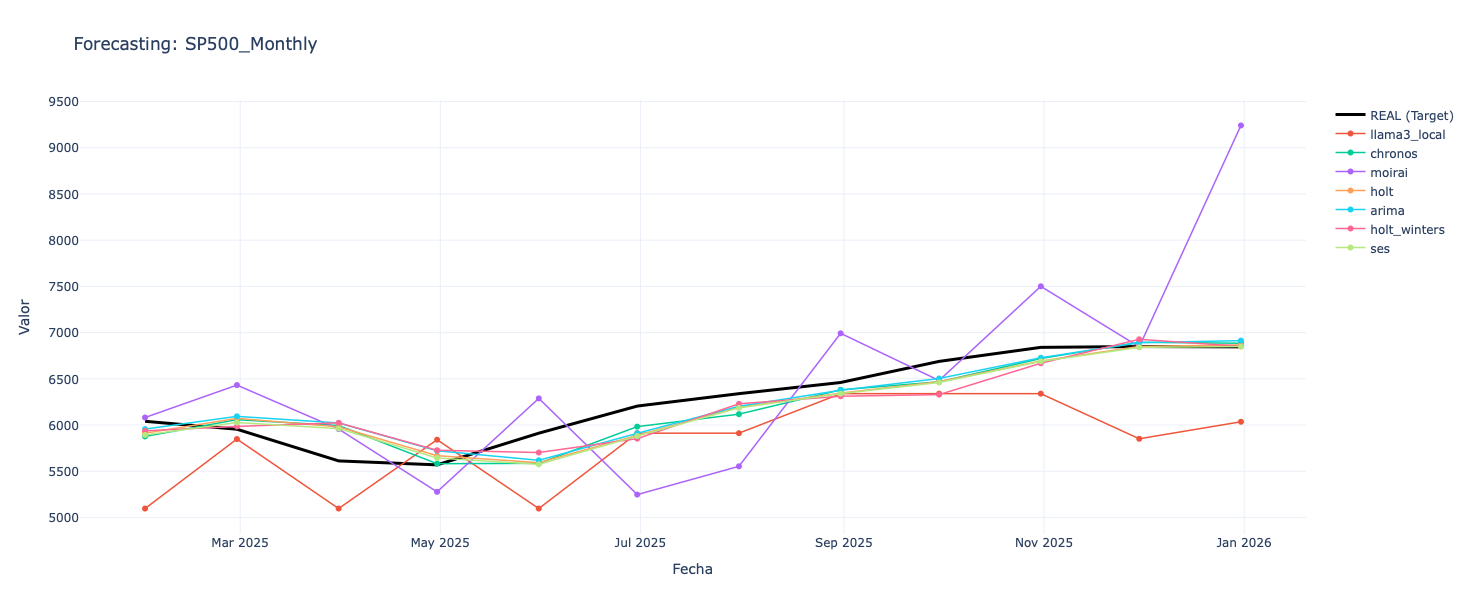

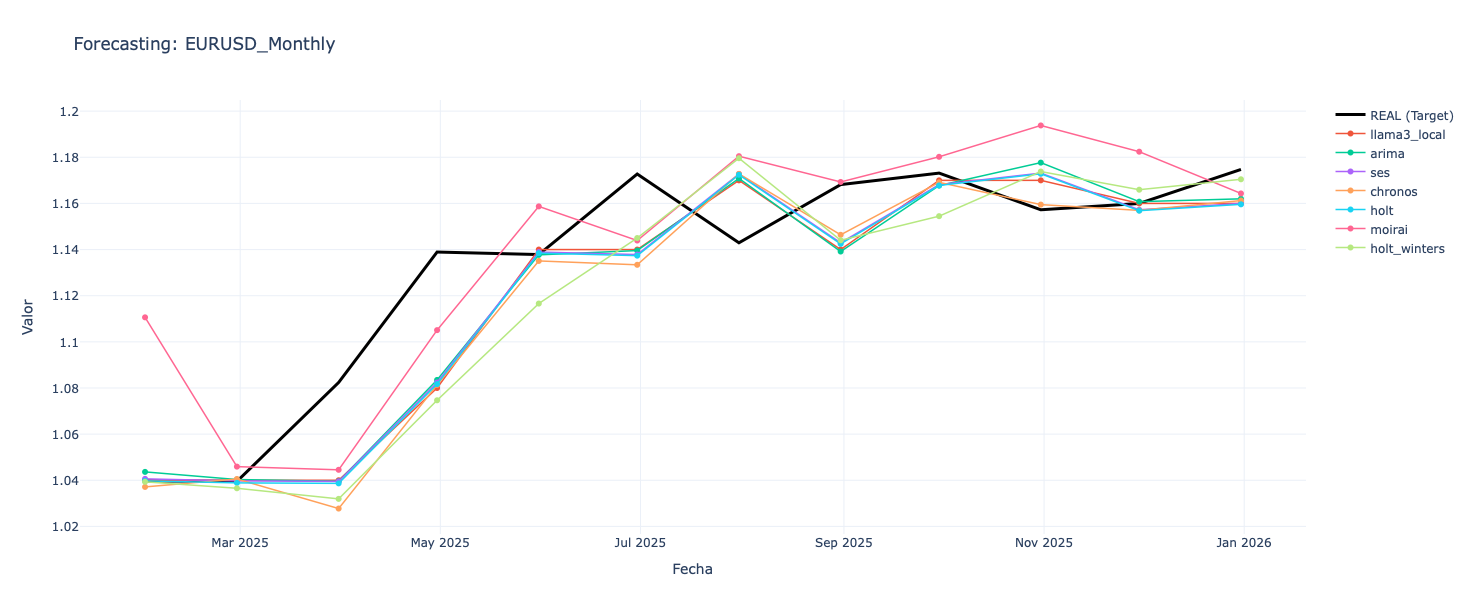

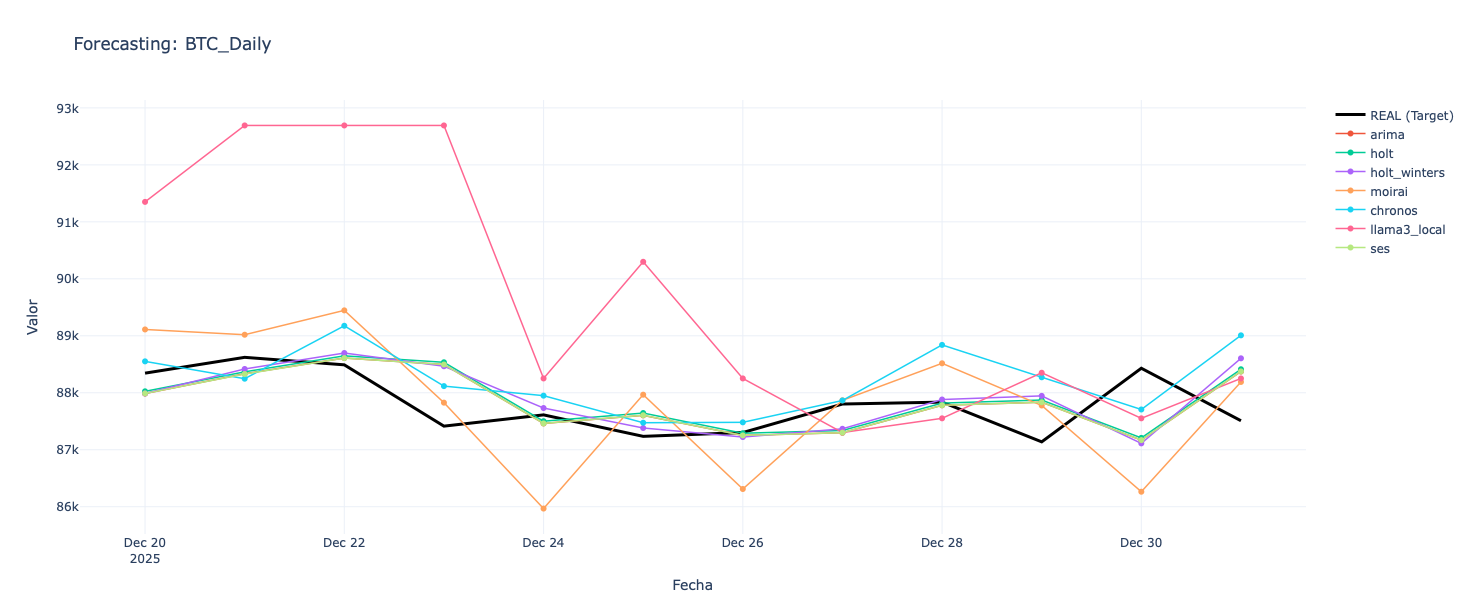

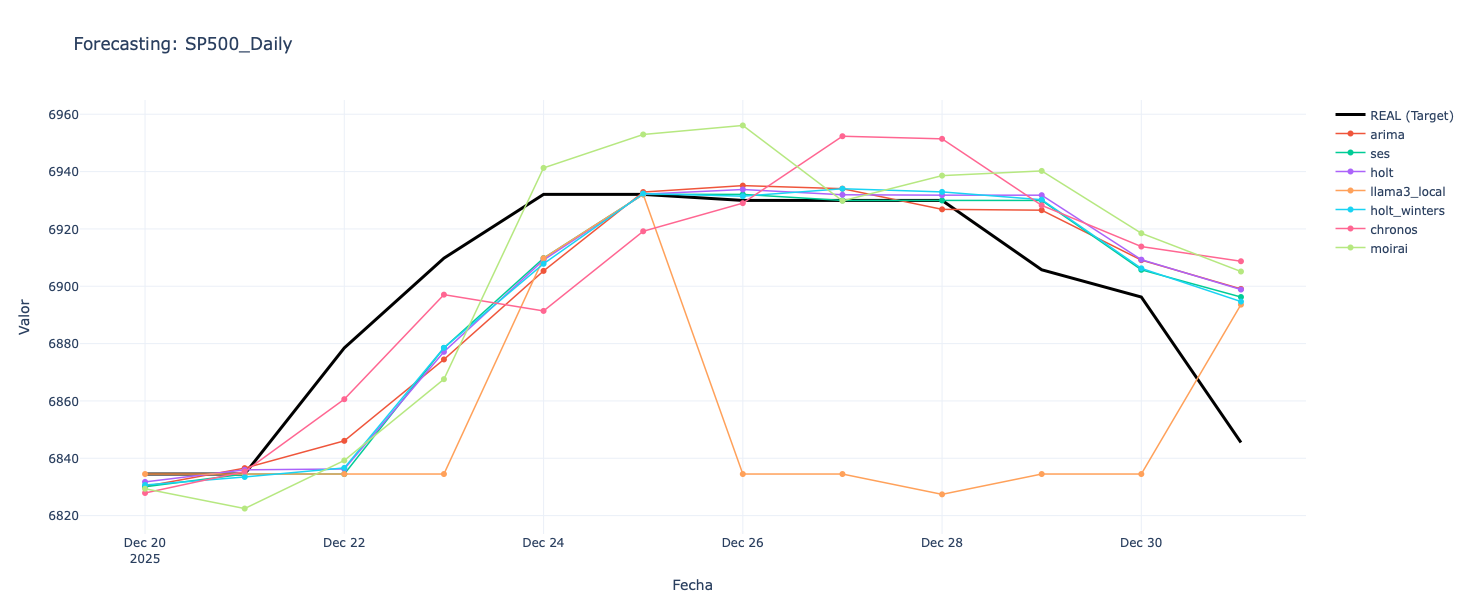

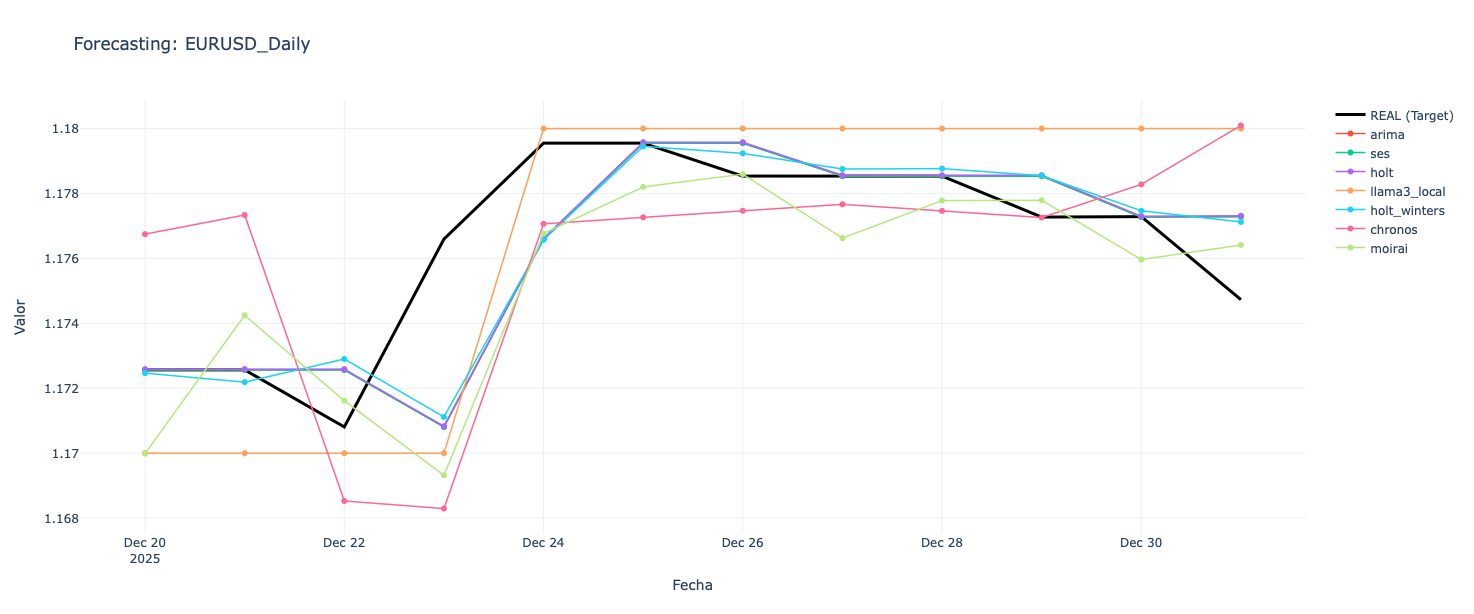

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

# 1. CARGA DE DATOS
def load_data():
    if not os.path.exists("results/summary_metrics.csv"):
        print("❌ Error: No se encuentran los archivos en la carpeta 'results/'")
        return None, None
    
    summary = pd.read_csv("results/summary_metrics.csv")
    detailed = pd.read_csv("results/detailed_predictions.csv")
    detailed['Date'] = pd.to_datetime(detailed['Date'])
    
    # Ordenar por fecha para que las líneas salgan bien
    detailed = detailed.sort_values('Date')
    
    print("✅ Datos cargados correctamente.")
    return summary, detailed

summary_df, detailed_df = load_data()

# ==========================================
# 2. ANÁLISIS DE ERROR (RMSE)
# ==========================================
if summary_df is not None:
    # Filtramos MOIRAI si distorsiona mucho (opcional, click en la leyenda para ocultar)
    fig_rmse = px.bar(
        summary_df, 
        x='Dataset', 
        y='RMSE', 
        color='Model', 
        barmode='group',
        title='Comparativa de Error (RMSE) por Dataset (Menor es mejor)',
        template='plotly_white',
        text_auto='.4f'
    )
    fig_rmse.update_layout(height=600)
    fig_rmse.show()

# ==========================================
# 3. FRONTERA DE EFICIENCIA (TIEMPO vs ERROR)
# ==========================================
if summary_df is not None:
    fig_eff = px.scatter(
        summary_df, 
        x='inference_time', 
        y='RMSE', 
        color='Model', 
        symbol='Dataset',
        size=[15] * len(summary_df), # Tamaño fijo puntos
        log_x=True, # Escala logarítmica para el tiempo (vital para comparar Arima vs LLM)
        title='Trade-off: Coste Computacional vs Precisión (Escala Log)',
        hover_data=['Dataset', 'Model', 'RMSE', 'inference_time'],
        template='plotly_white'
    )
    # Líneas guía
    fig_eff.update_layout(height=600, xaxis_title="Tiempo Inferencia (segundos) [Log]", yaxis_title="RMSE")
    fig_eff.show()

# ==========================================
# 4. PREDICCIONES VS REALIDAD (Una gráfica por Dataset)
# ==========================================
if detailed_df is not None:
    datasets = detailed_df['Dataset'].unique()
    
    for ds in datasets:
        subset = detailed_df[detailed_df['Dataset'] == ds]
        
        fig = go.Figure()
        
        # 1. Línea Real (Ground Truth)
        # Cogemos los valores únicos de fecha/realidad
        real_data = subset[['Date', 'y_true']].drop_duplicates().sort_values('Date')
        
        fig.add_trace(go.Scatter(
            x=real_data['Date'], 
            y=real_data['y_true'],
            mode='lines',
            name='REAL (Target)',
            line=dict(color='black', width=3)
        ))
        
        # 2. Líneas de Modelos
        models = subset['Model'].unique()
        for model in models:
            model_data = subset[subset['Model'] == model]
            
            # Opcional: Hacer Moirai invisible por defecto si es muy malo
            visible = 'legendonly' if model == 'MOIRAI' else True
            
            fig.add_trace(go.Scatter(
                x=model_data['Date'], 
                y=model_data['y_pred'],
                mode='lines+markers',
                name=model,
                visible=visible,
                line=dict(width=1.5)
            ))
            
        fig.update_layout(
            title=f'Forecasting: {ds}',
            xaxis_title='Fecha',
            yaxis_title='Valor',
            template='plotly_white',
            hovermode="x unified", # Muestra todos los valores al pasar el ratón
            height=600
        )
        fig.show()